$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$


In [ ]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available else {}
print("Using device: ", device)

manualSeed = 1
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Using device:  cuda


In [ ]:
batch_size = 100

dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
print(len(dataset))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2)
print(len(dataloader))

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
50000
500


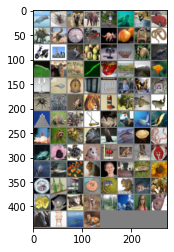

torch.Size([100, 3, 32, 32])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

x = iter(dataloader)
images, labels = x.next()
imshow(torchvision.utils.make_grid(images))
print(images.size())

In [ ]:
n_classes = 100
embedding_dim = 100
latent_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator.to(device)
generator.to(device)

GeneratorModel(
  (label_embedding): Embedding(100, 100)
  (hidden_layer1): Sequential(
    (0): Linear(in_features=200, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=3072, bias=True)
    (1): Tanh()
  )
)

In [ ]:
a = torch.ones(10,100)
b = torch.ones(10,1)
b = b.long()
a = a.to(device)
b = b.to(device)
features = generator(a,b)
print(features.size())
output = discriminator(features,b)
print(output.size())

torch.Size([10, 3072])
torch.Size([10, 1])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(generator))
print(count_parameters(discriminator))

3867152
3915537


In [ ]:
adversarial_loss = nn.BCELoss()

def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
learning_rate = 0.00002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

Epoch: [1/10]: D_loss: 0.317, G_loss: 1.220
Epoch: [2/10]: D_loss: 0.072, G_loss: 3.381
Epoch: [3/10]: D_loss: 0.044, G_loss: 4.466
Epoch: [4/10]: D_loss: 0.038, G_loss: 5.019
